# 3 Data Pre-processing


Data pre-processing techniques refer to addition, deletion, or transformation of training set data. Data prepration can make or break a model's preditive ability. The need for data pre-processing is determined by the type of model being used. Some models are less or more sensitive to data. The tree based models are typically insensitive to data and models like linear regressions are not.

The pre-processing techniques discussed in this chapter are focus on **Unsupervised** data models (e.g. PCA) that do not consider the outcome variable in the pre-processing. The **supervised**  methods that do take them into consideration (e.g. partial least squares) the outcome variables will be discussed in later chapters.

*The dataset used to illustrate pre-processing examples is discussed next.*


## 3.1 Case Study: Cell Segmentation in High-Content Screening

To measure the effects of medicines or diseases on the size, shape, development status, and number of cells in living organizm or plant, experts, examines the target serum or tissue under miscroscope and maually assess the desired characteristis. This processes is tedious and a better approach is to use high-contrast screening. 

The high-contrast screening works by measuring the light reflected from a stain that binds to specific characteristic of cell such as cell nuclei. However, this automated method often results in misleading measurements. One such problem is the error in automatic detection of cell boundaries. The researchers assembled a dataset consisting of **2019** cells, where **1300** were judged to be poorly segmented (PS) and **719** were all well segmented (WS). The training/test split of roughly 50% data was used. 

*Lets explore the dataset in little more detail.*

In [1]:
import random

import pandas as pd

import numpy as np

from scipy.stats import boxcox, pearsonr
import scipy.cluster.hierarchy as hcluster

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import glob

import matplotlib.pyplot as plt

%matplotlib inline  

plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

plt.gray()


In [2]:
datasets = glob.glob('./datasets/segmentationData/*.csv')

In [3]:
datasets

['./datasets/segmentationData/segmentationData.csv']

In [4]:
segData = pd.read_csv(datasets[0])
segData.head()

,Unnamed: 0,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
0,1,207827637,Test,PS,143.247705,185,15.711864,4.954802,9.548023,2.214689,...,2781,701.0,1690,392,12.474676,7.609035,2.714100,10.642974,42,14
1,2,207932307,Train,PS,133.752037,819,31.923274,206.878517,69.916880,164.153453,...,24964,160998.0,54675,128368,18.809225,56.715352,118.388139,32.161261,215,347
2,3,207932463,Train,WS,106.646387,431,28.038835,116.315534,63.941748,106.696602,...,11552,47511.0,26344,43959,17.295643,37.671053,49.470524,21.185525,371,252
3,4,207932470,Train,PS,69.150325,298,19.456140,102.294737,28.217544,31.028070,...,5545,28870.0,8042,8843,13.818968,30.005643,24.749537,13.392830,487,295
4,5,207932455,Test,PS,2.887837,285,24.275735,112.415441,20.474265,40.577206,...,6603,30306.0,5569,11037,15.407972,20.504288,45.450457,13.198561,283,159


#### List of predictors 

The researchers used different stains that would be visible to different optical channels. 
* Channel one was associated with the cell body and can be used to determine the cell perimeter, area, and other qualities. 
* Channel two interrogated the cell nucleus by staining the nuclear DNA 
* Channels three and four were stained to detect actin and tubulin, respectively. 



In [5]:
len(list(segData))


62

In [6]:
print (list(segData), end="\n")

['Unnamed: 0', 'Cell', 'Case', 'Class', 'AngleCh1', 'AreaCh1', 'AvgIntenCh1', 'AvgIntenCh2', 'AvgIntenCh3', 'AvgIntenCh4', 'ConvexHullAreaRatioCh1', 'ConvexHullPerimRatioCh1', 'DiffIntenDensityCh1', 'DiffIntenDensityCh3', 'DiffIntenDensityCh4', 'EntropyIntenCh1', 'EntropyIntenCh3', 'EntropyIntenCh4', 'EqCircDiamCh1', 'EqEllipseLWRCh1', 'EqEllipseOblateVolCh1', 'EqEllipseProlateVolCh1', 'EqSphereAreaCh1', 'EqSphereVolCh1', 'FiberAlign2Ch3', 'FiberAlign2Ch4', 'FiberLengthCh1', 'FiberWidthCh1', 'IntenCoocASMCh3', 'IntenCoocASMCh4', 'IntenCoocContrastCh3', 'IntenCoocContrastCh4', 'IntenCoocEntropyCh3', 'IntenCoocEntropyCh4', 'IntenCoocMaxCh3', 'IntenCoocMaxCh4', 'KurtIntenCh1', 'KurtIntenCh3', 'KurtIntenCh4', 'LengthCh1', 'NeighborAvgDistCh1', 'NeighborMinDistCh1', 'NeighborVarDistCh1', 'PerimCh1', 'ShapeBFRCh1', 'ShapeLWRCh1', 'ShapeP2ACh1', 'SkewIntenCh1', 'SkewIntenCh3', 'SkewIntenCh4', 'SpotFiberCountCh3', 'SpotFiberCountCh4', 'TotalIntenCh1', 'TotalIntenCh2', 'TotalIntenCh3', 'TotalIn

In [7]:
segData.describe()

,Unnamed: 0,Cell,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
count,2019.000000,2.019000e+03,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000
mean,1010.000000,2.084024e+08,90.493405,320.336305,126.071679,189.052115,96.420171,140.701586,1.205859,0.895764,...,37245.123328,52258.089153,26759.650322,40551.359584,72.197502,98.554872,120.021172,17.623982,260.727093,177.343239
std,582.979416,2.790457e+05,48.760000,214.023533,165.008380,158.956105,96.666921,146.634665,0.202522,0.076108,...,61836.388435,46496.512752,27758.916848,46312.198211,79.690885,96.908200,112.108618,6.166931,140.365593,107.720132
min,1.000000,2.078276e+08,0.030876,150.000000,15.160401,1.000000,0.120000,0.563265,1.005831,0.510623,...,2382.000000,1.000000,24.000000,96.000000,11.466564,0.869253,2.301536,6.393216,9.000000,8.000000
25%,505.500000,2.083325e+08,53.892207,193.000000,35.364158,44.998572,33.495694,40.679739,1.065236,0.856972,...,9499.500000,14367.000000,8776.000000,9939.000000,25.302948,36.704721,47.426963,13.820393,142.000000,88.000000
50%,1010.000000,2.083843e+08,90.588773,253.000000,62.343173,173.506329,67.431250,90.250000,1.148620,0.913262,...,18285.000000,49220.000000,18749.000000,24839.000000,42.500015,69.116555,87.250451,16.187731,262.000000,165.000000
75%,1514.500000,2.084052e+08,126.682013,362.500000,143.187785,279.289699,127.341651,191.170427,1.280514,0.955606,...,35716.500000,72495.000000,35277.000000,55004.000000,81.771899,123.839112,159.136619,19.784021,382.000000,253.000000
max,2019.000000,2.109641e+08,179.939323,2186.000000,1418.634831,989.509804,1205.511538,886.837500,2.900320,0.996499,...,741411.000000,363311.000000,313433.000000,519602.000000,642.024719,757.020963,933.524313,54.744763,501.000000,501.000000


**Class labels**

In [8]:
segData.Class.unique()

array(['PS', 'WS'], dtype=object)

**Training/Testing Split**

In [9]:
segData.groupby('Case')['Case'].count()

Case
Test     1010
Train    1009
Name: Case, dtype: int64

In [10]:
segDataTrain = segData[segData.Case == 'Train']
segDataTest = segData[segData.Case == 'Test']

segDataTrain.head()

,Unnamed: 0,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1,2,207932307,Train,PS,133.752037,819,31.923274,206.878517,69.916880,164.153453,...,24964,160998.0,54675,128368,18.809225,56.715352,118.388139,32.161261,215,347
2,3,207932463,Train,WS,106.646387,431,28.038835,116.315534,63.941748,106.696602,...,11552,47511.0,26344,43959,17.295643,37.671053,49.470524,21.185525,371,252
3,4,207932470,Train,PS,69.150325,298,19.456140,102.294737,28.217544,31.028070,...,5545,28870.0,8042,8843,13.818968,30.005643,24.749537,13.392830,487,295
11,12,207932484,Train,WS,109.416426,256,18.828571,126.938776,13.600000,46.800000,...,4613,30856.0,3332,11466,13.922937,18.643027,40.331747,17.546861,211,495
14,15,207932459,Train,PS,104.278654,258,17.570850,125.368421,22.461538,71.206478,...,4340,30720.0,5548,17588,12.324971,17.747143,41.928533,17.660339,172,207


## 3.2 Data Transformaiton for Individual Predictors

Individual predictors might need transformation for several reasons. The model might require that all predictors adhere to a common scale. The skweness or outliners in the data can also make it harder to build a quality models. Such situation need to be handled before building a model. 

*Next lets look at different type of data transformation involving invidual predictors.*

### Centering and Scaling

Most common form of transformation is to center scale the predictor variables. This is done by simply subtracting the average value of the predictor from all values. This will give the predictor mean of zero. To scale, each predictor is divided by its standard deviation. 

**Pros** : All the data in your model will now have a common scale with zero mean and standard deviation of 1. This offers more numerical stability and 

**Cons**: One downside is that you lose the interpretability of the individual values since that data is no longer in the original units. 

### Transformations to Resolve Skewness

An un-skewed distribution is the one that is roughly symmetric. This means that the probability of falling on either side of the distribution's mean is roughly equal. 

A *right-skewed* distribution has large number of points on the left side of the distribution (smaller values) then on the right side (larger values). Two ways we can get an idea about the skewness in the data.

1. If the ratio of highest to the lowest value is high (> 20), than data have significant skewness. 
2. The skewness statistics can also be used as a diagnostic tool. 

A roughly symmetric distribution will have the skewness value close to zero, right skewed distribution have a large positive value, and for left skewed this value becomes negative. The formula for skewness is given below:

\begin{align}
skewness = \frac{\sum(x_i - \bar{x})^3}{(n-1)v^{\frac{3}{2}}} \\
where \space v = \frac{\sum(x_i - \bar{x})^2}{(n-1)},
\end{align}

where x is the predictor variable, n is the number of values, and $\bar{x}$ is the sample mean of the predictor.

**An example of right skewed data**: The plot below shows a histogram of the standard deviation of the intensity of the pixels in actin filaments (Channel 3). The plot on the left is in natural units, whereas the right plot shows the same data after a log transformation. 

Text(0,0.5,'Count')

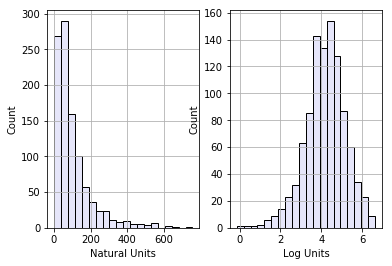

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(segDataTrain.VarIntenCh3.values, bins=20, color='lavender')
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(np.log(segDataTrain.VarIntenCh3.values), bins=20, color='lavender')
ax2.set_xlabel('Log Units')
ax2.set_ylabel('Count')

The predictor above has a strong skewnewss with a concentration of points with low values. Here ratio of the smallest to the largest value is 870 with a skewness value of 2.39. The skewness value drops to -0.4 when the same data is logged. 

In [12]:
def skewness(X):
    " Compute the skewness statistics"
    N = X.count()
    mu = np.mean(X)
    v = np.dot(X-mu, X-mu) / (N -1)
    
    return np.sum( (X-mu) **3) / ( (N -1) * v ** (3/2))
    
def ratio_larget_to_smallest(X):
    return max(X) / min(X)

print ("Skewness statistics of natural data ", skewness(segDataTrain.VarIntenCh3))
print ("Ratio of largest to smallest value ", ratio_larget_to_smallest(segDataTrain.VarIntenCh3))
print ("Skewness statistics of log data ", skewness(np.log(segDataTrain.VarIntenCh3)))

Skewness statistics of natural data  2.393996977110011
Ratio of largest to smallest value  870.8872472027832
Skewness statistics of log data  -0.4041869635031983


**Box-Cox**: A direct method to empirically identify appropriate transformation is propsed by Box and Cox. These trnasformations are indexed by a parameter $\lambda$. The training data is used for estimating the value of $\lambda$ using maximum likelihood estimation. 

\begin{align}
    x^*=
     \begin{cases}
      \frac{x^\lambda -1}{\lambda}, & \text{if}\ \lambda \neq 1 \\
      log(x), & \text{if}\ \lambda = 0
    \end{cases}
\end{align}

In addition to log transformations, the box-cox family can identify square transformations ( $\lambda = 2$), square root ( $\lambda = 0.5$), inverse ( $\lambda = -1$).  

The plot below shows the histogram of cell perimeter predictor. *Left*: plot with natural units. *Right*: the same data after Box-Cox transformation with $\lambda$ estimated to be -1.1. 

Box-Cox lambda value = -1.09128437890813


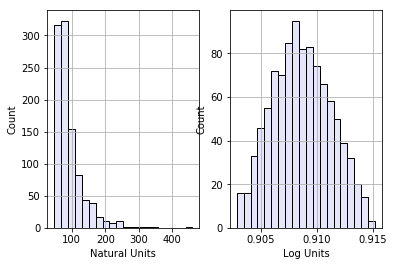

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(segDataTrain.PerimCh1.values, bins=20, color='lavender')
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(boxcox(segDataTrain.PerimCh1.values)[0], bins=20, color='lavender')
ax2.set_xlabel('Log Units')
ax2.set_ylabel('Count')

print ("Box-Cox lambda value = {}".format(boxcox(segDataTrain.PerimCh1.values)[1]))

## 3.3 Data Transformations for Multiple Predictors

These transformations act on groups of predictors. 

### Transformations to Resolve Outliers

Outliers are samples that are exceptionally far from the mainstream of the data. Suspected outlier samples need to carefully evaluated to make sure that they are otherwise valid and no data recording errors have occured. Additionaly, the outlying data may be an indication of a special part of the population that is just starting to be sampled. 

Certain **models are resistant to outlier**. Tree based are usually not affected by outliers. Also, support vector machines also ignores portion of the training samples that might be far away from the decision boundary. 


If a model is sensitive to outliers, a **spatial sign** transformation can minimize the problem. It projects the predictor values onto a multidimensional sphere. This has the effect of making all the samples the same distance from the center of the sphere. Mathematiclaly, each sample is divided by its square norm:

\begin{align}
x_{ij}^{*} = \frac{x_{ij}}{\sum_{j=1}^Px_{ij}^2}
\end{align}

It is important to center and scale the predictor data prior to using the spatial sign transformation as the denominator above is intended to measure the square distance to the center of the predictor's distribution. 




*Below we generate few linear samples drawn from an equation of line and then add random noise to it. *

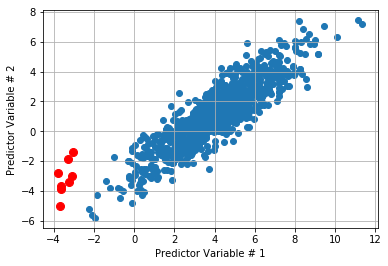

In [14]:
N = 1000
slope, intercept = 0.9, -2.5
X = np.random.normal(4, 2, N)
Y = intercept + (slope * X + np.random.normal(size = N))

X_outliers = np.random.uniform(-4, -3, 8)
Y_outliers = X_outliers + np.random.normal(size = 8)

plt.scatter(X, Y)
plt.plot(X_outliers, Y_outliers, 'ro', markersize=8)
plt.xlabel("Predictor Variable # 1")
plt.ylabel("Predictor Variable # 2")
plt.show()

Text(0,0.5,'Predictor Variable # 2')

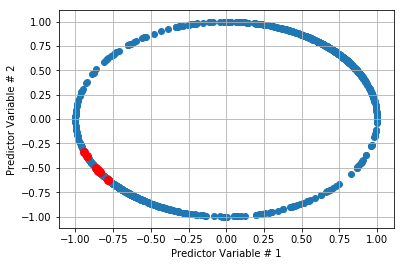

In [15]:
from sklearn.preprocessing import scale

X_all = scale(np.concatenate((X, X_outliers)))
Y_all = scale(np.concatenate((Y, Y_outliers)))

Xij = np.squeeze(np.dstack((X_all, Y_all)))
X_all = Xij[:, 0] / np.linalg.norm(Xij, axis=1)
Y_all = Xij[:, 1] / np.linalg.norm(Xij, axis=1)

plt.scatter(X_all[:-8], Y_all[:-8])
plt.plot(X_all[-7:], Y_all[-7:], 'ro', markersize=8)
plt.xlabel("Predictor Variable # 1")
plt.ylabel("Predictor Variable # 2")

The outlier still exists in the dataset but now are contracted inwards. 

### Data Reduction and Feature Extraction

These methods reduce the data by generating smaller set of predictors to capture a majority of the information. Usually the new smaler set of predictors captures the maximum amount of information from the original data.

One such technique is **PCA** that find linear cominations of predictors, known as principal components (PCs), which capture the most possible variance. The first PC is defined as the linear combination of the predictors that capture the most variability of all possible linear combinations. 

Mathematically, the jth PC can be written as:

$PC_j = (a_{j1} \times Predictor 1) + (a_{j2} \times Predictor 2) + \cdots (a_{jp} \times Predictor P).$

P is the number of predictors. The coefficients $a_{j1},a_{j2}, \times , a_{jp}$ are called component weights and help us understand which predictors are most important to each PC. 

To demonstrate the PCA, lets consider two of the variables from the cell segmentaiton data: Average pixel intensity of channel 1 and entropy of values in the cell (a measure of cell shape), and a categorical response. These two variables have a correlation value of 0.93. 


In [16]:
AvgIntenCh1 = scale(boxcox(segDataTrain.AvgIntenCh1)[0])
EntropyIntenCh1 = scale(boxcox(segDataTrain.EntropyIntenCh1)[0])

print("Pearson coefficient for AvgIntenCh1 and EntropyIntenCh1 {}".format(pearsonr(AvgIntenCh1, EntropyIntenCh1)[0]))

Pearson coefficient for AvgIntenCh1 and EntropyIntenCh1 0.9327413450412335


Given, the high correlation coefficient between these predictors, we can infer that these measure the redundent information about the cells and that either predictor or a linear combination of these predictors could be used in the place of the original predictors. 

Below, we drive two PCs. 


In [17]:
from sklearn.decomposition import PCA

AvgIntenCh1_PS     = AvgIntenCh1[segDataTrain.Class == 'PS']
AvgIntenCh1_WS   = AvgIntenCh1[segDataTrain.Class == 'WS']
EntropyIntenCh1_PS = EntropyIntenCh1[segDataTrain.Class == 'PS']
EntropyIntenCh1_WS = EntropyIntenCh1[segDataTrain.Class == 'WS']

X = np.squeeze(np.dstack((AvgIntenCh1, EntropyIntenCh1)))

pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

print ("Varriance explained by PCA {}".format(pca.explained_variance_ratio_))
print("Pearson coefficient for AvgIntenCh1 and EntropyIntenCh1 Transformed {}".format(pearsonr(X_pca[:, 0], X_pca[:, 1])[0]))

Varriance explained by PCA [0.96637067 0.03362933]
Pearson coefficient for AvgIntenCh1 and EntropyIntenCh1 Transformed 9.277515521262832e-17


The first PC summarizes 97% of the original variance in the data. It is reasonable to use just the first PC for modeling. 

The plot below shows the original and transformed data. 

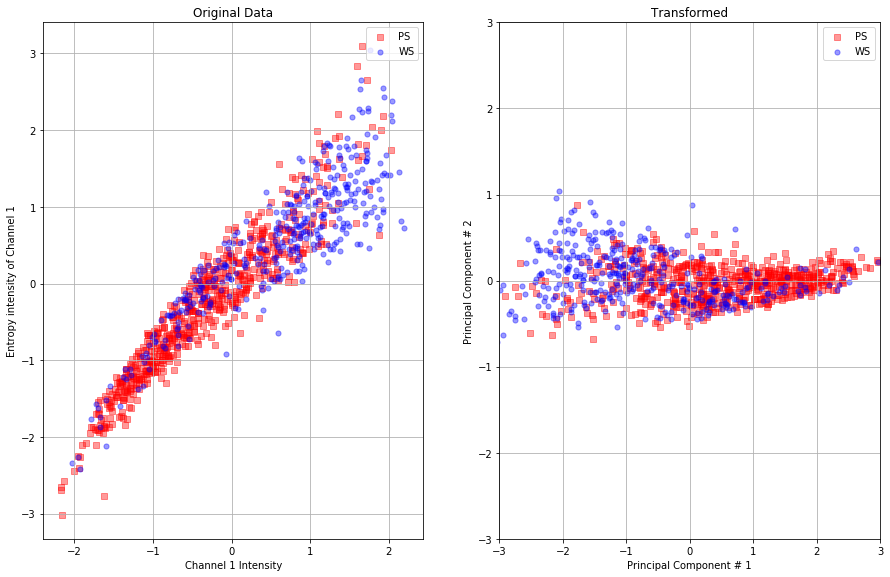

In [18]:
fig = plt.figure(figsize=(15,9.5))
plt.subplot(121)
plt.scatter(AvgIntenCh1_PS, EntropyIntenCh1_PS, color='r', marker='s', alpha=0.4, s=26, label='PS')
plt.scatter(AvgIntenCh1_WS, EntropyIntenCh1_WS, color='b', marker='o', alpha=0.4, s=26, label='WS')
plt.title('Original Data')
plt.xlabel('Channel 1 Intensity')
plt.ylabel('Entropy intensity of Channel 1')
plt.legend(loc='upper right')

plt.subplot(122)
plt.scatter(X_pca[segDataTrain.Class == 'PS', 0], X_pca[segDataTrain.Class == 'PS', 1], color='r', marker='s', alpha=0.4, s=26, label='PS')
plt.scatter(X_pca[segDataTrain.Class == 'WS', 0], X_pca[segDataTrain.Class == 'WS', 1], color='b', marker='o', alpha=0.4, s=26, label='WS')
plt.axis([-3, 3, -3, 3])
plt.title('Transformed')
plt.xlabel('Principal Component # 1')
plt.ylabel('Principal Component # 2')
plt.legend(loc='upper right')


**Things to remember when applying PCA**:  

* It creates components that are uncorrelated.
* PCA seeks predictor-set variation wihtout regard to any further understanding of the predictors (i.e. measurement scales or distributions). 
* To avoid summarizing distributional differences and predictor scale information, it is best to first transform sekewed predictors and then center and scale the predictors prior to transforming PCA. 
* It does not take into consideration the response (output) variable when summarizing variability. It is an **unsupervised technique**.

** Number of components to retain**

Once we have decided the appropriate transformations of the predictor variables, we can then apply PCA. For data sets with many predictor variables, we must decide how many components to retain. A heuristic approach for determining the number of components to retain is to create a scree plot, which contains the ordered component number (x-axis) and the amount of variability (y-axis). 

In [19]:
segDataTrainFeatures = segDataTrain.iloc[:, 4:]
segDataTrainFeatures.head()

,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,DiffIntenDensityCh1,DiffIntenDensityCh3,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1,133.752037,819,31.923274,206.878517,69.916880,164.153453,1.263158,0.797080,31.875000,43.122283,...,24964,160998.0,54675,128368,18.809225,56.715352,118.388139,32.161261,215,347
2,106.646387,431,28.038835,116.315534,63.941748,106.696602,1.053310,0.935475,32.487710,35.985770,...,11552,47511.0,26344,43959,17.295643,37.671053,49.470524,21.185525,371,252
3,69.150325,298,19.456140,102.294737,28.217544,31.028070,1.202625,0.865829,26.732283,22.917323,...,5545,28870.0,8042,8843,13.818968,30.005643,24.749537,13.392830,487,295
11,109.416426,256,18.828571,126.938776,13.600000,46.800000,1.081871,0.920460,28.020045,14.870824,...,4613,30856.0,3332,11466,13.922937,18.643027,40.331747,17.546861,211,495
14,104.278654,258,17.570850,125.368421,22.461538,71.206478,1.075728,0.931300,27.876106,16.119469,...,4340,30720.0,5548,17588,12.324971,17.747143,41.928533,17.660339,172,207


In [20]:
segDataTrainScaled = scale(segDataTrainFeatures, with_mean=True, with_std=True)

pca = PCA()
pca.fit(segDataTrainScaled)
segDataTrainTr = pca.transform(segDataTrainScaled)
print(segDataTrainTr[0:5, 0:4])

[[ 5.10110331  4.55363749 -0.03346814 -2.64164812]
 [-0.25475238  1.19862667 -1.02110181 -3.7329293 ]
 [ 1.29353529 -1.86485912 -1.25172504 -2.41605421]
 [-1.4653876  -1.56660922  0.46985377 -3.39039623]
 [-0.8767117  -1.27963977 -1.33860611 -3.51853779]]


In [21]:
# Loadings (rotations) , row corresponds to components and column corresponds to predictor variables
print(pca.components_[0:5, 0:4])

[[ 0.00121376  0.22917187 -0.10270878 -0.15482867]
 [-0.01284461  0.16061734  0.17971332  0.16376018]
 [ 0.00681647  0.08981173  0.06769674  0.0735344 ]
 [-0.0275572  -0.05523062  0.18675619  0.04145772]
 [-0.02523673 -0.05273468 -0.02401245 -0.07839174]]


In [22]:
pos_indx = np.where(segDataTrainFeatures.apply(lambda x: np.all(x > 0)))[0]
segDataTrainFeaturesPos = segDataTrainFeatures.iloc[:, pos_indx]
segDataTrainFeaturesNeg = segDataTrainFeatures.drop(segDataTrainFeatures.columns[pos_indx], axis=1, inplace=False)

segDataTrainFeaturesPosTr = segDataTrainFeaturesPos.apply((lambda x : boxcox(x)[0]))
segDataTrainFeaturesTr = np.c_[segDataTrainFeaturesPosTr, segDataTrainFeaturesNeg]
segDataTrainFeaturesTr = scale(segDataTrainFeaturesTr, with_mean=True, with_std=True)


pca = PCA()
pca.fit(segDataTrainFeaturesTr)
segDataTrainTr = pca.transform(segDataTrainFeaturesTr)
print(segDataTrainTr[0:5, 0:4])


[[ 1.40425248  6.31234279 -0.42898785 -3.21371049]
 [-0.8099386   2.04353928 -1.49309799 -4.77216651]
 [ 3.74187545 -0.19334515 -0.43773887 -4.05982811]
 [ 0.33831386 -2.10122419  1.60966744 -5.3534083 ]
 [ 1.05304125 -1.42466815 -0.8181903  -5.71919444]]


The first five components account for [0.22263674 0.18671972 0.13571945 0.07803299 0.04745241] of the total variance
All together they account for 0.670561319754895 of the total variance


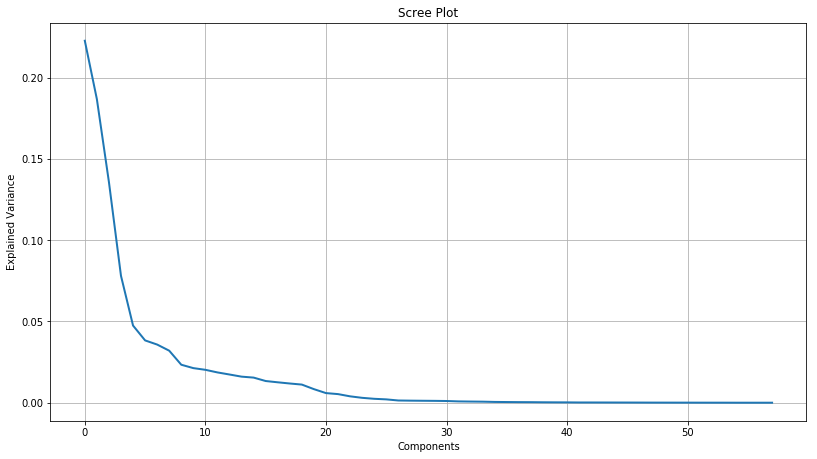

In [23]:
plt.figure(1, figsize=(15, 7.9))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.title('Scree Plot')
plt.xlabel('Components')
plt.ylabel('Explained Variance')

print ("The first five components account for {0} of the total variance".format(pca.explained_variance_ratio_[:5]))
print ("All together they account for {0} of the total variance".format(np.sum(pca.explained_variance_ratio_[:5])))


Another way to judge the effectiveness of the principle component is to look at them visually. This can be done by plotting the first few components against each other. If PCA has captured a sufficient amount of information in the data, this type of plot can demonstrate clusters of samples or outliers that may prompt a closer examination of the individual data points. 

Text(0.5,0.06,'Scatter Plot Matrix')

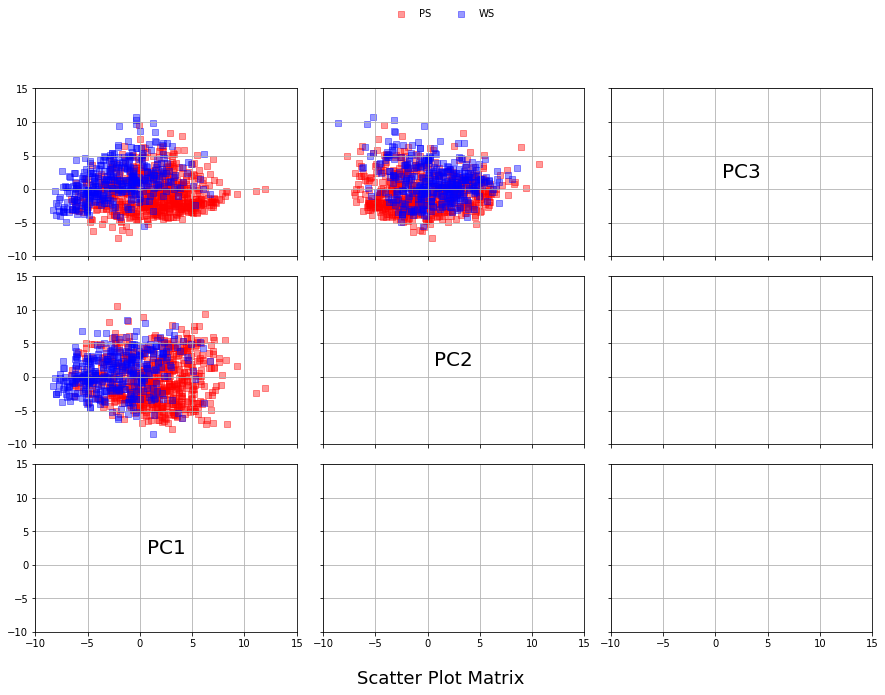

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)

axes = plt.gca()
axes.set_xlim([-10,15])
axes.set_ylim([-10,15])

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

l0 = ax[0, 0].scatter(segDataTrainTr[segDataTrain.Class == 'PS', 0], segDataTrainTr[segDataTrain.Class == 'PS', 2], color='r', marker='s', alpha=0.4, s=26, label='PS')
l1 = ax[0, 0].scatter(segDataTrainTr[segDataTrain.Class == 'WS', 0], segDataTrainTr[segDataTrain.Class == 'WS', 2], color='b', marker='s', alpha=0.4, s=26, label='WS')
ax[0, 1].scatter(segDataTrainTr[segDataTrain.Class == 'PS', 1], segDataTrainTr[segDataTrain.Class == 'PS', 2], color='r', marker='s', alpha=0.4, s=26, label='PS')
ax[0, 1].scatter(segDataTrainTr[segDataTrain.Class == 'WS', 1], segDataTrainTr[segDataTrain.Class == 'WS', 2], color='b', marker='s', alpha=0.4, s=26, label='WS')

ax[1, 0].scatter(segDataTrainTr[segDataTrain.Class == 'PS', 0], segDataTrainTr[segDataTrain.Class == 'PS', 1], color='r', marker='s', alpha=0.4, s=26, label='PS')
ax[1, 0].scatter(segDataTrainTr[segDataTrain.Class == 'WS', 0], segDataTrainTr[segDataTrain.Class == 'WS', 1], color='b', marker='s', alpha=0.4, s=26, label='WS')

ax[0, 2].text(0.5*(left+right), 0.5*(bottom+top), 'PC3', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax[0, 2].transAxes)
ax[1, 1].text(0.5*(left+right), 0.5*(bottom+top), 'PC2', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax[1, 1].transAxes)
ax[2, 0].text(0.5*(left+right), 0.5*(bottom+top), 'PC1', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax[2, 0].transAxes)

fig.legend([l0, l1], ('PS', 'WS'), loc='upper center', ncol=2, frameon=False)
fig.subplots_adjust(hspace=0.12, wspace=0.1)
fig.text(0.5, 0.06, 'Scatter Plot Matrix', ha='center', va='center', fontsize=18)



**In the above scatter plot** we plotted the first three components of cell segmentation data. Since the percentages of variation explained are not larger for the first three components, it is important to not to over-interpret the resulting images. There appears to be some seperation from the plot for PC1 vs PC2. However, the distribution of the well-segmented cells is roughly contained within the distribution of the poorly segmented. 

Another exploratory use of PCA is characterizing which predictors are associated with each component. Each component is a linear combination of the predictors and the coefficient for each predictor is called the loading. Loadings close to zero indicate that the predictor variable did not contribute much to that component. 

Text(0.5,0.06,'Scatter Plot Matrix')

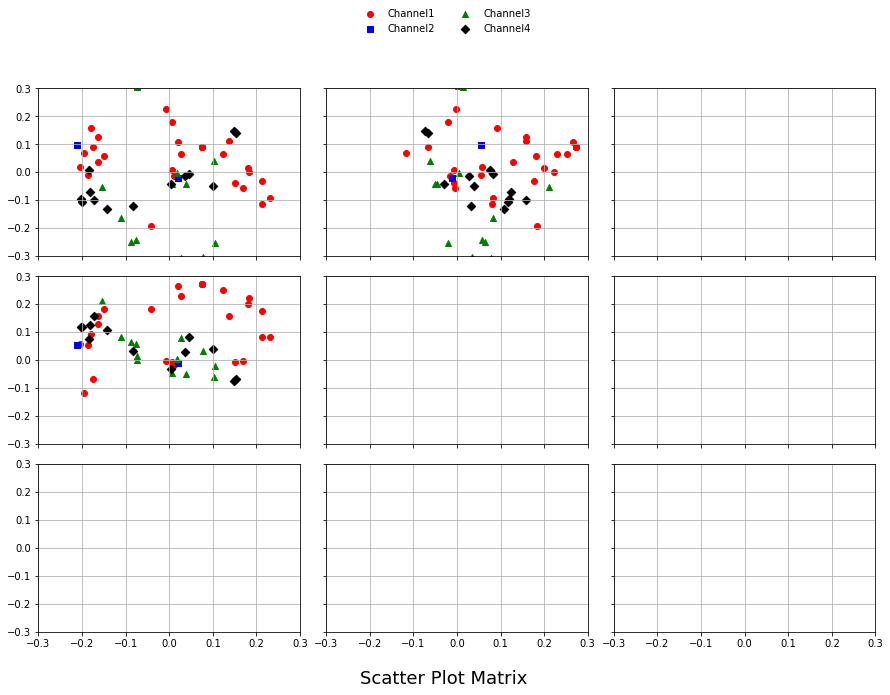

In [25]:
loadings = pca.components_

ch1_idx = [segDataTrainFeatures.columns.get_loc(c) for c in segData.columns[segData.columns.str.endswith('Ch1')]]
ch2_idx = [segDataTrainFeatures.columns.get_loc(c) for c in segData.columns[segData.columns.str.endswith('Ch2')]]
ch3_idx = [segDataTrainFeatures.columns.get_loc(c) for c in segData.columns[segData.columns.str.endswith('Ch3')]]
ch4_idx = [segDataTrainFeatures.columns.get_loc(c) for c in segData.columns[segData.columns.str.endswith('Ch4')]]

fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)

axes = plt.gca()
axes.set_xlim([-0.3,0.3])
axes.set_ylim([-0.3, 0.3])



l0 = ax[0, 0].scatter(loadings[0, ch1_idx], loadings[2, ch1_idx], marker='o', color='red', label='Channel1')
l1 = ax[0, 0].scatter(loadings[0, ch2_idx], loadings[2, ch2_idx], marker='s', color='blue', label='Channel2')
l2 = ax[0, 0].scatter(loadings[0, ch3_idx], loadings[2, ch3_idx], marker='^', color='green', label='Channel3')
l3 = ax[0, 0].scatter(loadings[0, ch4_idx], loadings[2, ch4_idx], marker='D', color='black', label='Channel4')

ax[0, 1].scatter(loadings[1, ch1_idx], loadings[2, ch1_idx], marker='o', color='red')
ax[0, 1].scatter(loadings[1, ch2_idx], loadings[2, ch2_idx], marker='s', color='blue')
ax[0, 1].scatter(loadings[1, ch3_idx], loadings[2, ch3_idx], marker='^', color='green')
ax[0, 1].scatter(loadings[1, ch4_idx], loadings[2, ch4_idx], marker='D', color='black')

ax[1, 0].scatter(loadings[0, ch1_idx], loadings[1, ch1_idx], marker='o', color='red')
ax[1, 0].scatter(loadings[0, ch2_idx], loadings[1, ch2_idx], marker='s', color='blue')
ax[1, 0].scatter(loadings[0, ch3_idx], loadings[1, ch3_idx], marker='^', color='green')
ax[1, 0].scatter(loadings[0, ch4_idx], loadings[1, ch4_idx], marker='D', color='black')

fig.legend([l0, l1, l2, l3], ('Channel1', 'Channel2', 'Channel3', 'Channel4'), loc='upper center', ncol=2, frameon=False)
fig.subplots_adjust(hspace=0.12, wspace=0.1)
fig.text(0.5, 0.06, 'Scatter Plot Matrix', ha='center', va='center', fontsize=18)


The plot above shows the loadings for the first three components in our data. Each point is a predictor variable and is colored by the optical channel. 

### 3.4 Dealing with Missing Values

Values can be structurally missing such as number of children a man has given birth to. In other cases, the values can not or was not determined.

**Informative missingness**: Pattern of missing data is related to the outcome. For example: In predicting a patentients response to a druge, that drug could be extremely ineffective. The patient may be likely to miss docotr visit or drop out of the study. In this case, there is clearly a relationship between the probability of missing values and the treatment. Similarly, customer rates products when they have strong opinion - either good or bad. There could be very few values in the middle. 

**Censored data** : Different from issing data as as something is known about its value. For example, in a measuring instrument can not measure below a certain value. In such cases, we know that the value is smaller than the limit but not precisely measured. 

Missing data might also bbe concentrated in a subset of predictors than occuring randomy across all the predictors. In some cases, the percentage of missing data is substantial enough to remove this predictor from subsequent modeling. 

**Handling missing data** : If missingness is not informative, there are two general approaches to handling the missing data. (i) A few predictive model , such as tree based techniques, can specifically account for the missing data. (ii) missing data can be imputed. 

Text(0.5,1,'7NN')

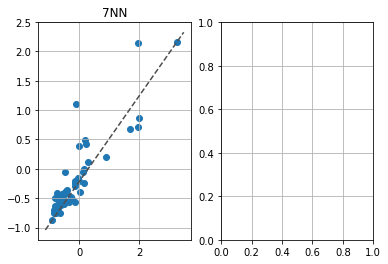

In [26]:
nn = NearestNeighbors(n_neighbors = 7)

# Drop the column to be imputed
segDataTrainSubset = segDataTrainFeatures.drop('VarIntenCh3', 1)
VarItenCh3Train = segDataTrainFeatures['VarIntenCh3'].values.reshape(-1, 1)

# Sample 50 test examples, Drop the intensity channel 3, Scale the dataset
segDataTestSubset = segDataTest.iloc[random.sample(range(segDataTest.shape[0]), 50)]
VarIntenCh3Original = segDataTestSubset['VarIntenCh3'].values.reshape(-1, 1)
segDataTestSubset = segDataTestSubset.iloc[:, 4:].drop('VarIntenCh3', 1)

sc1 = StandardScaler()
segDataTrainSubsetSC = sc1.fit_transform(segDataTrainSubset)
segDataTestSubsetSC  = sc1.transform(segDataTestSubset)

sc2 = StandardScaler()
VarItenCh3Train = sc2.fit_transform(VarItenCh3Train)
VarIntenCh3Original = sc2.transform(VarIntenCh3Original)

# Apply nearest neighbour
nn.fit(segDataTrainSubsetSC)
distance, indices = nn.kneighbors(segDataTestSubsetSC)

VarIntenCh3Imputed = np.empty(50)
for idx, i in enumerate(indices):
    VarIntenCh3Imputed[idx] = np.mean(VarItenCh3Train[i[1:]])

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(VarIntenCh3Original, VarIntenCh3Imputed)
# ax1.set(xlim=(-1.5, 3), ylim=(-1.5, 3))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
ax1.set_title('7NN')

# TODO Apply linear model 

### 3.5 Removing Predictors

- Fewere predictors means decreased computational time and complexity
- Highly correlated predictors don't add too much value and might be measuring the same undelrying information
- Certain models can be crippled by predictors with degenerate distributions. 

Detecting and removing **near-zero** variance predictors. 

The near-zero variance predictors are the one that don't add too much information to the model. Secondly, they might cause problem for the model. The rule of thumb for detecting such predictors is:

- The fraction of unique values over the sample size is low (~ 10%)
- The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (~ 20)

If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.

#### Between-Predictor Correlations

Collinearity is the technical term for the situation where a pair of pre- dictor variables have a substantial correlation with each other. Below shows a correlation matrix of the training set. Each pairwise correlation is computed from the training data and colored according to its magnitude. This visualization is symmetric: the top and bottom diagonals show identical information. Dark blue colors indicate strong negative corre- lations, dark red is used for strong positive correlations, and white implies no empirical relationship between the predictors.


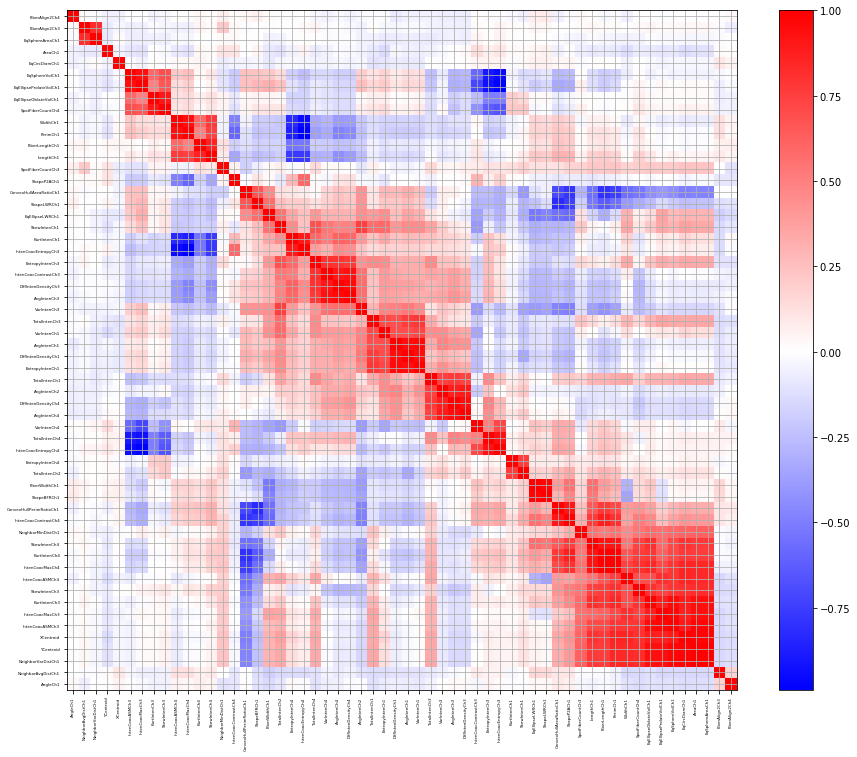

In [27]:
segDataTrainCorr = np.array(segDataTrainFeatures.corr())
cols = segDataTrainFeatures.columns
Y = hcluster.linkage(segDataTrainCorr, 'single', 'correlation')
Z = hcluster.dendrogram(Y, color_threshold=0, no_plot=True)['leaves']

# Re-order correlation data based on hierarchical cluster ordering.
segDataTrainCorr = segDataTrainCorr[Z, :]
segDataTrainCorr = segDataTrainCorr[:, Z]
cols = cols[Z]

plt.figure(figsize=(15, 12.5))
plt.imshow(segDataTrainCorr, interpolation='nearest', aspect='auto', cmap='bwr')
plt.colorbar()
plt.xticks(range(segDataTrainCorr.shape[0]), cols, rotation='vertical', fontsize=4)
plt.yticks(range(segDataTrainCorr.shape[0]), cols[::-1], fontsize=4)
plt.show()

Classical regression has many tools to diagnose multi-collinearlity for linear regression. One such method is called the variance inflation factor (VIF). 

A less theoretical, more heuristic approach to dealing with this issue is to remove the minimum number of predictors to ensure that all pairwise correlation are below a certain threshold. Here is a simple algorithm:

1. Calculate the correlation matrix of the predictors.
2. Determine the two pedictors associated with the largest absolute pairwise correlation (call them predictors A and B).
3. Determine the average correlation between A and the other variables.Do the same for predictor B.
4. If A has a larger average correlation, remove it; otherwise, remove predic-tor B.
5. Repeat Steps 2–4 until no absolute correlations are above the threshold.

### 3.6 Adding Predicates

#### Creating Dummy Variables





In [ ]:
# cars = pd.read_csv('./datasets/cars/cars.csv')
# print(cars.columns)
# carsSub = cars[['Price', 'Milsage', 'Type']]
# carsSub.head()


### 3.7 Binning Predicates

One common approach to avoid is manually 'bin' numeric/continous data prior to analysis. This can lead to significant loss in performance. here are several models, such as clas- sification/regression trees and multivariate adaptive regression splines, that estimate cut points in the process of model building. The difference between these methodologies and manual binning is that the models use all the predic- tors to derive bins based on a single objective (such as maximizing accuracy). They evaluate many variables simultaneously and are usually based on sta- tistically sound methodologies. 